# Tree Clumps Fire

This notebook simulates the process of determining which tree clumps to target to prevent fire spread in a forest. The trees are represented by a graph where nodes are the tree clumps and the edges are connections though which fire can spread. The separation is achieved though the use of the D-Wave hybrid solver performing Quadratic Unconstrained Binary Optimization (QUBO), based on the Immunization Strategy example available through D-Wave (https://github.com/dwave-examples/immunization-strategy). The goal is to assign each node into two main groups and a separator group in such a way that no edges exist between the two main groups, a situation which we will call *complete separation*. The results for four variations are compared:
1. Setting $k$, the number of separator nodes, and starting with $k=1$, assign nodes to groups in an attempt to achieve complete separation. Increase the number of separators by one each iteration until complete separation is achieved. Say complete separation is achieved at $k=n$. 
    * Note that each itertion does not depend on the previous one, i.e. the separator nodes for $k$ do not depend on those for $(k-1)$
2. Calculate *hubness* for each node (discussed in the Optimization section). Repeat the optimization for $k=1,\ldots,n$ but set the separator nodes based on descending order of hubness, i.e. use the $k$ nodes with the highest hubness as the separators. 
    * Note that 1. did not set the separator nodes, just the number of separator nodes, whereas here we are assigning the separator nodes before the optimization.
3. Repeat the optimization for $k=1,\ldots,n$ but set the separator nodes by randomly selecting from the final optimal set of $n$ nodes.
4. Repeat the optimization for $k=1,\ldots,n$ but set the separator nodes from the final optimal set of $n$ nodes based on descending order of hubness. 
    * Note that 2. did not require the nodes to be from the final optimal set

Specifically, we will compare the number of *illegal edges*, those connecting the two main groups.

To run this notebook you will need:
* A D-Wave API key from the D-Wave Leap IDE (https://cloud.dwavesys.com/leap/login/?next=/leap/)
* File for the tree clumps graph (here called `fire_graph.pkl`)
* If you wish to visualize the graph on a map,
    * File for the coordinates of the graph nodes (here called `fire_centroids.pkl`)
    * Coordinates for the bounding box of the graph on a map, of the form `active_zone_bounds =  ((long1, long2),(lat1, lat2))`

# Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import geopandas as gpd
from shapely import affinity, Polygon, Point
import folium
# from folium import plugins
# from folium.plugins import HeatMap
import osmnx as ox
from math import radians, cos, sin, asin, sqrt
import requests
import urllib
import networkx as nx
import pickle
from scipy import stats

Image.MAX_IMAGE_PIXELS = None

from dimod import ConstrainedQuadraticModel, Binary, quicksum
from dwave.system import LeapHybridCQMSampler

# import branca.colormap as cm
# from matplotlib.colors import Normalize
from branca.element import Template, MacroElement
from copy import deepcopy
import random

## Functions

In [3]:
# --------------------------------------------
# MISC. FUNCTIONS
# --------------------------------------------
def get_poly_sqr_from_bounds(active_zone_bounds):
    
    active_zone_ll = Polygon([[active_zone_bounds[0][0],active_zone_bounds[1][0]],
                              [active_zone_bounds[0][1],active_zone_bounds[1][0]],
                              [active_zone_bounds[0][1],active_zone_bounds[1][1]],
                              [active_zone_bounds[0][0],active_zone_bounds[1][1]],
                              [active_zone_bounds[0][0],active_zone_bounds[1][0]]])

    return active_zone_ll

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 3956 #6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

In [4]:
# --------------------------------------------
# ORIGINAL D-WAVE FUNCTIONS
# --------------------------------------------


# Original function for building constrained quadratic model
def build_cqm(G):
    """ Build the CQM for the problem instance."""

    # Two groups (cases 0, 1) and one separator group (case 2)
    num_groups = 3

    # Initialize the CQM object
    print("\nBuilding CQM...")
    cqm = ConstrainedQuadraticModel()

    # Build the CQM starting by creating variables
    vars = [[Binary(f'x_{name}_{i}') for i in range(num_groups)] for name in G.nodes()]

    # Set objective for CQM
    cqm.set_objective(quicksum(vars[i][2] for i in range(len(vars))))

    # Add constraint to make variables discrete
    for v in range(len(vars)):
        cqm.add_discrete([f'x_{v}_{i}' for i in range(num_groups)])

    # Add constraint to CQM: |G1|=|G2|
    g1 = [vars[i][0] for i in range(len(vars))]
    g2 = [vars[i][1] for i in range(len(vars))]
    cqm.add_constraint(quicksum(g1) - quicksum(g2) <= 1)
    cqm.add_constraint(quicksum(g1) - quicksum(g2) >= -1)

    # Add constraint to CQM: e(G1, G2) = 0
    edge_sum = []
    for a, b in G.edges():
        if a != b:
            edge_sum.append(vars[a][0]*vars[b][1]+vars[a][1]*vars[b][0])
    cqm.add_constraint(quicksum(edge_sum) == 0, label='cross edges')

    return cqm

def run_cqm_and_collect_solutions(cqm, sampler):
    """ Send the CQM to the sampler and return the best sample found."""

    # Initialize the solver
    print("\nSending to the solver...")
    
    # Solve the CQM problem using the solver
    sampleset = sampler.sample_cqm(cqm, label='Tree Fire')

    # Get the first feasible solution
    feasible_sampleset = sampleset.filter(lambda d: d.is_feasible)
    if len(feasible_sampleset) == 0:
        print("\nNo feasible solution found. Returning best infeasible solution.")
        return sampleset.first.sample

    return feasible_sampleset.first.sample

def process_sample(G, sample):
    """ Interpret the CQM solution in terms of the partitioning problem."""

    # Display results to user
    group_1 = []
    group_2 = []
    sep_group = []
    results = [[],[],[]]
    for key, val in sample.items(): # key is of form "x_{node}_{group #}" and val is 0 or 1
        if val == 1:
            v = key.split("_")
            results[int(v[-1])].append(int(v[1]))

    group_1 = results[0]
    group_2 = results[1]
    sep_group = results[2]

    # Display best result
    print("\nPartition Found:")
    print("\tGroup 1: \tSize", len(group_1))
    print("\tGroup 2: \tSize", len(group_2))
    print("\tSeparator: \tSize", len(sep_group))

    print("\nSeparator Fraction: \t", len(sep_group)/len(G.nodes()))

    # Determines if there are any edges directly between the large groups
    illegal_edges = [(u, v) for u, v in G.edges if (sample[f'x_{u}_{0}']*sample[f'x_{v}_{1}'] == 1 or sample[f'x_{u}_{1}']*sample[f'x_{v}_{0}'] == 1)]

    print("\nNumber of illegal edges:\t", len(illegal_edges))

    return group_1, group_2, sep_group, illegal_edges

def visualize_results(G, group_1, group_2, sep_group, illegal_edges, save = False):
    """ Visualize the partition."""

    print("\nVisualizing output...")

    G1 = G.subgraph(group_1)
    G2 = G.subgraph(group_2)
    SG = G.subgraph(sep_group)

    pos_1 = nx.random_layout(G1, center=(-5,0))
    pos_2 = nx.random_layout(G2, center=(5,0))
    pos_sep = nx.random_layout(SG, center=(0,0))
    pos = {**pos_1, **pos_2, **pos_sep}

    nx.draw_networkx_nodes(G, pos_1, node_size=10, nodelist=group_1, node_color='#17bebb', edgecolors='k')
    nx.draw_networkx_nodes(G, pos_2, node_size=10, nodelist=group_2, node_color='#2a7de1', edgecolors='k')
    nx.draw_networkx_nodes(G, pos_sep, node_size=10, nodelist=sep_group, node_color='#f37820', edgecolors='k')

    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), style='solid', edge_color='#808080')
    nx.draw_networkx_edges(G, pos, edgelist=illegal_edges, style='solid')

    # plt.draw()
    if save:
        output_name = 'separator.png'
        plt.savefig(output_name)
        print("\tOutput stored in", output_name)
    plt.show()
    # plt.close()
    




In [5]:
# --------------------------------------------
# MODIFIED D-WAVE FUNCTIONS
# --------------------------------------------


def build_cqm_tol(G, tolerance = 'default'):
    """ Build the CQM for the problem instance."""
    # Original function for building constrained quadratic model, group size constraint with tolerance
    
    # Two groups (cases 0, 1) and one separator group (case 2)
    num_groups = 3

    # Initialize the CQM object
    print("\nBuilding CQM...")
    cqm = ConstrainedQuadraticModel()

    # Build the CQM starting by creating variables
    vars = [[Binary(f'x_{name}_{i}') for i in range(num_groups)] for name in G.nodes()]

    # Set objective for CQM
    cqm.set_objective(quicksum(vars[i][2] for i in range(len(vars))))

    # Add constraint to make variables discrete
    for v in range(len(vars)):
        cqm.add_discrete([f'x_{v}_{i}' for i in range(num_groups)])

    # Add constraint to CQM: | |G1|-|G2| | <= tolerance
    if tolerance == 'default':
        tolerance = (len(G.nodes))/40
    g1 = [vars[i][0] for i in range(len(vars))]
    g2 = [vars[i][1] for i in range(len(vars))]
    cqm.add_constraint(quicksum(g1) - quicksum(g2) <= tolerance)
    cqm.add_constraint(quicksum(g1) - quicksum(g2) >= tolerance)

    # Add constraint to CQM: e(G1, G2) = 0
    edge_sum = []
    for a, b in G.edges():
        if a != b:
            edge_sum.append(vars[a][0]*vars[b][1]+vars[a][1]*vars[b][0])
    cqm.add_constraint(quicksum(edge_sum) == 0, label='cross edges')

    return cqm

# --------------------------------------------
# Using Separator Bounds and preassignment
# --------------------------------------------
def preassign(G, split, bound1, bound2):
    # Returns nodes outside of bound1 and bound2 as two lists
    if bound1 >= bound2:
        raise Exception("bound1 must be smaller than bound2")
    
    pre_G1 = []
    pre_G2 = []
           
    if split in ['vertical','longitude']:
        for node in G.nodes():
            c = centroids[node]
            if c.x <= bound1:
                pre_G1.append(node)
            elif c.x >= bound2:
                pre_G2.append(node)
                
    elif split in ['horizontal','latitude']:
        for node in G.nodes():
            c = centroids[node]
            if c.y <= bound1:
                pre_G1.append(node)
            elif c.y >= bound2:
                pre_G2.append(node)
    
    return pre_G1, pre_G2

def build_cqm_pa(G, pre_G1, pre_G2):
    """ Build the CQM for the problem instance."""
    # CQM with objective being minimizing the number of separators, but includes preassignment
    # Includes size constraint on groups
    
    # Two groups (cases 0, 1) and one separator group (case 2)
    num_groups = 3

    # Initialize the CQM object
    print("\nBuilding CQM...")
    cqm = ConstrainedQuadraticModel()

    # Build the CQM starting by creating variables
    vars = [[Binary(f'x_{name}_{i}') for i in range(num_groups)] for name in G.nodes()]

    # Set objective for CQM
    cqm.set_objective(quicksum(vars[i][2] for i in range(len(vars))))

    # Add constraint to make variables discrete
    for v in range(len(vars)):
        cqm.add_discrete([f'x_{v}_{i}' for i in range(num_groups)])

    # Add constraint to CQM: |G1|=|G2|
    g1 = [vars[i][0] for i in range(len(vars))]
    g2 = [vars[i][1] for i in range(len(vars))]
    cqm.add_constraint(quicksum(g1) - quicksum(g2) <= 1)
    cqm.add_constraint(quicksum(g1) - quicksum(g2) >= -1)

    # Add constraint to CQM: e(G1, G2) = 0
    edge_sum = []
    for a, b in G.edges():
        if a != b:
            edge_sum.append(vars[a][0]*vars[b][1]+vars[a][1]*vars[b][0])
    cqm.add_constraint(quicksum(edge_sum) == 0, label='cross edges')
    
    # Fix variables from preassignment
    for node in pre_G1:
        cqm.fix_variables({f'x_{node}_0': 1, f'x_{node}_1': 0, f'x_{node}_2': 0})
    for node in pre_G2:
        cqm.fix_variables({f'x_{node}_0': 0, f'x_{node}_1': 1, f'x_{node}_2': 0})

    return cqm

def build_cqm_pa_tol(G, pre_G1, pre_G2, tolerance = 'default'):
    """ Build the CQM for the problem instance."""
    # CQM with objective being minimizing the number of separators, but includes preassignment and a tolerance on group size
    
    # Two groups (cases 0, 1) and one separator group (case 2)
    num_groups = 3

    # Initialize the CQM object
    print("\nBuilding CQM...")
    cqm = ConstrainedQuadraticModel()

    # Build the CQM starting by creating variables
    vars = [[Binary(f'x_{name}_{i}') for i in range(num_groups)] for name in G.nodes()]

    # Set objective for CQM
    cqm.set_objective(quicksum(vars[i][2] for i in range(len(vars))))

    # Add constraint to make variables discrete
    for v in range(len(vars)):
        cqm.add_discrete([f'x_{v}_{i}' for i in range(num_groups)])

    # Add constraint to CQM: | |G1| - |G2| | < = tolerance
    if tolerance == 'default':
        tolerance = (len(G.nodes))/40
    g1 = [vars[i][0] for i in range(len(vars))]
    g2 = [vars[i][1] for i in range(len(vars))]
    cqm.add_constraint(quicksum(g1) - quicksum(g2) <= tolerance)
    cqm.add_constraint(quicksum(g1) - quicksum(g2) >= -tolerance)

    # Add constraint to CQM: e(G1, G2) = 0
    edge_sum = []
    for a, b in G.edges():
        if a != b:
            edge_sum.append(vars[a][0]*vars[b][1]+vars[a][1]*vars[b][0])
    cqm.add_constraint(quicksum(edge_sum) == 0, label='cross edges')
    
    # Fix variables from preassignment
    for node in pre_G1:
        cqm.fix_variables({f'x_{node}_0': 1, f'x_{node}_1': 0, f'x_{node}_2': 0})
    for node in pre_G2:
        cqm.fix_variables({f'x_{node}_0': 0, f'x_{node}_1': 1, f'x_{node}_2': 0})

    return cqm

def build_cqm_preassigned(G, size, pre_G1, pre_G2):
    """ Build the CQM for the problem instance."""
    # CQM with objective being minimizing the number of cross edges, and with the number of separators given (size).
    # Also includes preassignment.

    # Two groups (cases 0, 1) and one separator group (case 2)
    num_groups = 3

    # Initialize the CQM object
    print("\nBuilding CQM...")
    cqm = ConstrainedQuadraticModel()

    # Build the CQM starting by creating variables
    vars = [[Binary(f'x_{name}_{i}') for i in range(num_groups)] for name in G.nodes()]

    # Set objective for CQM: minimize e(G1, G2)
    edge_sum = []
    for a, b in G.edges():
        if a != b:
            edge_sum.append(vars[a][0]*vars[b][1]+vars[a][1]*vars[b][0])
    cqm.set_objective(quicksum(edge_sum))

    # Add constraint to make variables discrete
    for v in range(len(vars)):
        cqm.add_discrete([f'x_{v}_{i}' for i in range(num_groups)])
        

    # Add constraint to CQM: |G3|=size
    g3 = [vars[i][2] for i in range(len(vars))]
    cqm.add_constraint(quicksum(g3) == size)
    
    
    # Fix variables from preassignment
    for node in pre_G1:
        cqm.fix_variables({f'x_{node}_0': 1, f'x_{node}_1': 0, f'x_{node}_2': 0})
    for node in pre_G2:
        cqm.fix_variables({f'x_{node}_0': 0, f'x_{node}_1': 1, f'x_{node}_2': 0})
        
    return cqm

def process_sample_preassigned(G, sample, pre_G1, pre_G2):
    """ Interpret the CQM solution in terms of the partitioning problem."""
    # Display results to user
    group_1 = []
    group_2 = []
    sep_group = []
    results = [[],[],[]]
    for key, val in sample.items(): # key is of form "x_{node}_{group #}" and val is 0 or 1
        if val == 1:
            v = key.split("_")
            results[int(v[-1])].append(int(v[1]))
    
    # The sample does not include fixed variables, so you must manually add the preassigned ones
    group_1 = pre_G1+results[0]
    group_2 = pre_G2+results[1]
    sep_group = results[2]

    # Display best result
    print("\nPartition Found:")
    print("\tGroup 1: \tSize", len(group_1))
    print("\tGroup 2: \tSize", len(group_2))
    print("\tSeparator: \tSize", len(sep_group))

    print("\nSeparator Fraction: \t", len(sep_group)/len(G.nodes()))

    # Determines if there are any edges directly between the large groups
    # The sample does not include fixed variables, so you must manually include preassigned variable values
    # illegal_edges = [(u, v) for u, v in G.edges if (sample[f'x_{u}_{0}']*sample[f'x_{v}_{1}'] == 1 or sample[f'x_{u}_{1}']*sample[f'x_{v}_{0}'] == 1)]
    illegal_edges = []
    for u, v in G.edges:
        if u in pre_G1:
            xu0 = 1
            xu1 = 0
        elif u in pre_G2:
            xu0 = 0
            xu1 = 1 
        else:
            xu0 = sample[f'x_{u}_{0}']
            xu1 = sample[f'x_{u}_{1}']
        
        if v in pre_G1:
            xv0 = 1
            xv1 = 0
        elif v in pre_G2:
            xv0 = 0
            xv1 = 1 
        else:
            xv0 = sample[f'x_{v}_{0}']
            xv1 = sample[f'x_{v}_{1}']
        
        if xu0*xv1 == 1 or xu1*xv0 == 1:
            illegal_edges.append((u,v))
            
    print("\nNumber of illegal edges:\t", len(illegal_edges))

    return group_1, group_2, sep_group, illegal_edges

# --------------------------------------------
# Using Fixed Separators and preassignment
# --------------------------------------------

def build_cqm_from_sep_preassigned(G, separators, pre_G1, pre_G2):
    """ Build the CQM for the problem instance."""

    # Two groups (cases 0, 1) and one separator group (case 2)
    # We will set case 2 using given separators, so really there are just two groups.
    num_groups = 2

    # Initialize the CQM object
    print("\nBuilding CQM...")
    cqm = ConstrainedQuadraticModel()

    # Build the CQM starting by creating variables
    # Separators fixed, so just two group variables per non-separator node
    vars = [[Binary(f'x_{name}_{i}') for i in range(num_groups)] for name in G.nodes()]
    
    # Set objective for CQM: minimize e(G1, G2) = 0
    edge_sum = []
    for a, b in G.edges():
        if a != b:
            edge_sum.append(vars[a][0]*vars[b][1]+vars[a][1]*vars[b][0])
    cqm.set_objective(quicksum(edge_sum))
    

    # Add constraint to make variables discrete
    # for v in range(len(vars)):
    #     cqm.add_discrete([f'x_{v}_{i}' for i in range(num_groups - 1)])
    for name in G.nodes():
        cqm.add_discrete([f'x_{name}_{i}' for i in range(num_groups)])
    
    
    # Fix variables from pre-processing and separators
    for node in pre_G1:
        cqm.fix_variables({f'x_{node}_0': 1, f'x_{node}_1': 0})
    for node in pre_G2:
        cqm.fix_variables({f'x_{node}_0': 0, f'x_{node}_1': 1})
    for node in separators:
        cqm.fix_variables({f'x_{node}_0': 0, f'x_{node}_1': 0})
    
    return cqm

def process_sample_with_sep_preassigned(G, sample, separators, pre_G1, pre_G2):
    """ Interpret the CQM solution in terms of the partitioning problem."""

    # Display results to user
    group_1 = []
    group_2 = []
    # sep_group = []
    results = [[],[],[]]
    for key, val in sample.items(): # key is of form "x_{node}_{group #}" and val is 0 or 1
        if val == 1:
            v = key.split("_")
            results[int(v[-1])].append(int(v[1]))
            
    # The sample does not include fixed variables, so you must manually add the preassigned ones and the separators
    group_1 = pre_G1+results[0]
    group_2 = pre_G2+results[1]
    sep_group = separators

    # Display best result
    print("\nPartition Found:")
    print("\tGroup 1: \tSize", len(group_1))
    print("\tGroup 2: \tSize", len(group_2))
    print("\tSeparator: \tSize", len(sep_group))

    print("\nSeparator Fraction: \t", len(sep_group)/len(G.nodes()))

    # Determines if there are any edges directly between the large groups
    # The sample does not include fixed variables, so you must manually include preassigned variable values
    # illegal_edges = [(u, v) for u, v in G.edges if (sample[f'x_{u}_{0}']*sample[f'x_{v}_{1}'] == 1 or sample[f'x_{u}_{1}']*sample[f'x_{v}_{0}'] == 1)]
    illegal_edges = []
    for u, v in G.edges:
        if u not in separators and v not in separators:
            if u in pre_G1:
                xu0 = 1
                xu1 = 0
            elif u in pre_G2:
                xu0 = 0
                xu1 = 1 
            else:
                xu0 = sample[f'x_{u}_{0}']
                xu1 = sample[f'x_{u}_{1}']

            if v in pre_G1:
                xv0 = 1
                xv1 = 0
            elif v in pre_G2:
                xv0 = 0
                xv1 = 1 
            else:
                xv0 = sample[f'x_{v}_{0}']
                xv1 = sample[f'x_{v}_{1}']

            if xu0*xv1 == 1 or xu1*xv0 == 1:
                illegal_edges.append((u,v))
            
    print("\nNumber of illegal edges:\t", len(illegal_edges))

    return group_1, group_2, illegal_edges

In [6]:
# --------------------------------------------
# MAP FUNCTION
# --------------------------------------------

# Set up macro for including draggable legend on map
# https://nbviewer.org/gist/talbertc-usgs/18f8901fc98f109f2b71156cf3ac81cd
template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Legend</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:aqua;'></span>Group 1</li>
    <li><span style='background:black;'></span>Group 2</li>
    <li><span style='background:orange;'></span>Separator</li>
    <li><span style='background:magenta;'></span>Illegal Edge</li>

  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

macro = MacroElement()
macro._template = Template(template)

def visualize_map(G, group_1, group_2, sep_group, illegal_edges, split = '', bound1 = None, bound2 = None):
    lon, lat = active_zone_ll.centroid.coords[0]
    zoom_start_val = 11

    # Basemap
    m = folium.Map([lat, lon], tiles='OpenStreetMap', zoom_start=zoom_start_val)#, tiles='OpenStreetMap')

    # Bounding box around active zone = Red
    sim_geo = gpd.GeoSeries(active_zone_ll).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {"fill":False,"color": "red"})#orange"})
    geo_j.add_to(m)

    # Plot OSM Results
    for tree_geom in geometries['geometry']:

        if tree_geom.area > min_area:

            # Plot Polygon
            sim_geo = gpd.GeoSeries(tree_geom)#.simplify(tolerance=0.001)
            geo_j = sim_geo.to_json()
            geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {"color": "green", "width": 2})#orange"})
            geo_j.add_to(m)
            # polygons.append(tree_geom)
    
    # Plot separator range
    if bound1 is not None and bound2 is not None:
        if split in ['vertical','longitude']:
            folium.PolyLine([[active_zone_bounds[1][0],bound2],[active_zone_bounds[1][1],bound2]], dash_array = 10, color = 'orange').add_to(m)
            folium.PolyLine([[active_zone_bounds[1][0],bound1],[active_zone_bounds[1][1],bound1]], dash_array = 10, color = 'orange').add_to(m)
        elif split in ['horizontal','latitude']:
            folium.PolyLine([[bound2,active_zone_bounds[0][0]],[bound2,active_zone_bounds[0][1]]], dash_array = 10, color = 'orange').add_to(m)
            folium.PolyLine([[bound1,active_zone_bounds[0][0]],[bound1,active_zone_bounds[0][1]]], dash_array = 10, color = 'orange').add_to(m)

    # Plot edges
    for edge in G.edges():
        c1 = centroids[edge[0]]
        c2 = centroids[edge[1]]
        folium.PolyLine([[c1.y,c1.x],[c2.y,c2.x]], weight=1, opacity = 0.6).add_to(m) #color='#808080'
    
    # Plot nodes
    for node in G.nodes():
        if node in group_1:
            color = 'aqua'#'#17bebb'
        elif node in group_2:
            color = 'black'#'#2a7de1'
        elif node in sep_group:
            color = 'orange'#'#f37820'
        else:
            color = 'blue'

        folium.CircleMarker(location=[centroids[node].y, centroids[node].x],
                                radius=3,#2.5,
                                color = color).add_to(m)#weight=5, color = 'green').add_to(m)
    # Highlight illegal edges
    for edge in illegal_edges:
        c1 = centroids[edge[0]]
        c2 = centroids[edge[1]]
        folium.PolyLine([[c1.y,c1.x],[c2.y,c2.x]], weight=4, color='magenta').add_to(m)
    
    # Add draggable legend
    m.get_root().add_child(macro)
    
    return m

## Map Setup

In [7]:
# Set up bounds for the map
active_zone_bounds =  ((-122.00, -121.75),(37.00, 37.25))

active_zone_bounds

((-122.0, -121.75), (37.0, 37.25))

In [8]:
# Retrieve geometries from OpenStreetMap based on active_zone_bounds
active_zone_ll = get_poly_sqr_from_bounds(active_zone_bounds)
min_area = 1e-6

tags = {'landuse': ['forest'], 'natural': ['wood']} #

geometries = ox.geometries_from_bbox(active_zone_bounds[1][0], active_zone_bounds[1][1], 
                                     active_zone_bounds[0][0], active_zone_bounds[0][1], tags=tags)

geometries.reset_index(inplace = True)

/var/folders/zj/vmktlp8s15j4b99s6p7_szq1y7fkb_/T/ipykernel_12091/1616150774.py:7: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  geometries = ox.geometries_from_bbox(active_zone_bounds[1][0], active_zone_bounds[1][1],


## Graph Setup

In [9]:
# Load node coordinates and graph
with open('fire_centroids.pkl', 'rb') as handle:
    centroids = pickle.load(handle)

with open('fire_graph.pkl', 'rb') as handle:
    G = pickle.load(handle)

In [10]:
# Identify and remove isolated nodes
isolated = list(nx.isolates(G))
print("Isolated nodes:", isolated)

# Remove corresponding centroids and nodes
for i in sorted(isolated)[::-1]:
    centroids.pop(i)
G.remove_nodes_from(isolated)
print("Nodes removed")
# Re-label nodes to properly work with D-Wave functions
G = nx.convert_node_labels_to_integers(G, ordering='sorted')

Isolated nodes: [113, 118, 213, 327, 362, 387, 420, 443, 448, 488, 491, 493, 573, 653, 691, 692, 730, 777, 858, 859, 1072, 1103, 1185, 1248, 1298, 1481, 1526, 1585, 1614, 1637, 1674, 1686]
Nodes removed


In [11]:
print(len(centroids),len(G.nodes()))

1663 1663


Nodes: 1663 	Edges: 4212


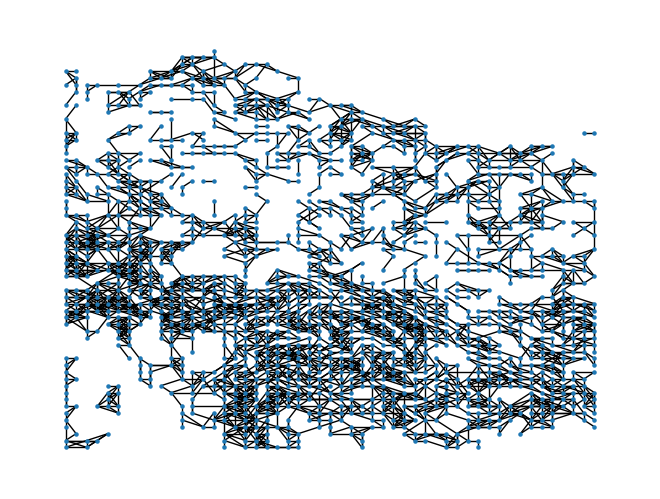

In [12]:
# Show networkx graph with coordinate positions
# positions = {}
# for i in range(len(centroids)):
#     centroid = centroids[i]
#     positions[i] = (centroid.x, centroid.y)
positions = [(centroid.x, centroid.y) for centroid in centroids]
print("Nodes:",len(G.nodes), "\tEdges:",len(G.edges))
nx.draw(G, positions, node_size = 5)

## D-Wave API Token

In [13]:
# Enter your D-Wave API token
my_token = ''

# Vertical Split (Separate East from West)

Here, we are imagining that we wish to prevent a fire from spreading East to West or vice versa by selecting tree clumps (nodes) to protect or intervene.

One way to help the QUBO understand that this is our intention is to "pre-assign" farthest nodes on the left and right sides of the graph. This means the QUBO has less nodes to assign itself and also will also try to assign groups to the nodes connected to these farthest nodes according to the pre-assigned groups. In this notebook, functions and variables associated with this process will have "preassign" or "pa" or "pre" in the name.

## Find "Minimal" Separator Number, Equally-sized Groups

We want to find reasonable estimate for how many separator nodes it will take to achieve complete separation. In this section, we use functions very similar to those in D-Wave's Immunization Strategy example where the two main groups are equally-sized, but this can be tweaked to use a tolerance (see next section) or pre-assignment.

In [14]:
# Build model with separation constraint
cqm = build_cqm(G)

# This is the part that uses up time on Leap.
# Run optimization.
sampler = LeapHybridCQMSampler(token=my_token)
sample = run_cqm_and_collect_solutions(cqm, sampler)

# Process results into classification groups and illegal edges
group_1, group_2, sep_group, illegal_edges = process_sample(G, sample)

visualize_results(G, group_1, group_2, sep_group, illegal_edges)

In [15]:
visualize_map(G, group_1, group_2, sep_group, illegal_edges)

## Find "Minimal" Separator Number, Group Size Tolerance

In [16]:
# Build model with separation constraint
cqm = build_cqm_tol(G, tolerance = 'default')

# This is the part that uses up time on Leap.
# Run optimization.
sampler = LeapHybridCQMSampler(token=my_token)
sample = run_cqm_and_collect_solutions(cqm, sampler)

# Process results into classification groups and illegal edges
group_1, group_2, sep_group, illegal_edges = process_sample(G, sample)

visualize_results(G, group_1, group_2, sep_group, illegal_edges)

In [17]:
visualize_map(G, group_1, group_2, sep_group, illegal_edges)

## Optimization

We will also calculate *hubness* in this optimization loop. Here, we are defining hubness to be the number of times a node appears in all of the sets of separators. For example, let's say we find complete separation of the graph with 10 separator nodes. Then there are 10 sets of separators, ranging from size 1 to 10. A node that appears in all 10 sets has a hubness of 10 and is likely to be more important for separation than a node that appears in only 2, i.e. hubness of 2.

A goal of hubness is to find an ordering to achieve better results, here meaning a lower number of illegal edges, faster, specifically compared to randomly selecting the order of points. For example, if complete separation is achieved with 10 separators, can hubness indicate a better ordering for selecting those nodes than random selection? In the context of our fire graph fire, this can be thought of as creating an ordering/prioritization for which trees to protect or intervene to prevent a fire from spreading from one side of the map to the other. Hubness also has important uses in other contexts, such as site construction: if a project for building $n$ sites is cut before completion, one would rather have used an ordering/prioritization like with hubness that maximizes results even with $k<n$ sites built, rather than having built in a random order.

In [18]:
# Set up separator bounds and preassignment
diff = active_zone_bounds[0][1] - active_zone_bounds[0][0]
bound1 = active_zone_bounds[0][0]+diff/10
bound2 = active_zone_bounds[0][1]-diff/10

pre_G1, pre_G2 = preassign(G, 'vertical', bound1, bound2)
print(len(G.nodes),len(pre_G1),len(pre_G2))

In [19]:
# !!! Warning !!! This cell uses Hybrid solver time on Leap. 
# You must use your own API token from Leap for my_token.

# Initialize dictionary for saving results and list for saving hubness counts
fire_results_dict = {}
fire_hubness_list = [0 for i in range(len(G.nodes()))]

# Iterate through size of separator class
for sep_size in range(1,l+1):
    
    print(f"Separator constraint = {sep_size}\n")
    
    # Build model with separation constraint
    cqm = build_cqm_preassigned(G, size=sep_size, pre_G1=pre_G1, pre_G2=pre_G2)

    # This is the part that uses up time on Leap.
    # Run optimization.
    sampler = LeapHybridCQMSampler(token=my_token)
    sample = run_cqm_and_collect_solutions(cqm, sampler)
    
    # Process results into classification groups and illegal edges
    group_1, group_2, sep_group, illegal_edges = process_sample_preassigned(G, sample, pre_G1, pre_G2)

    visualize_results(G, group_1, group_2, sep_group, illegal_edges)
    print("-"*75+"\n\n\n\n")
    
    # Save results
    # unhappiness = (# illegal edges) + (# separator nodes off from target separator constraint)
    result = {
        'sep_group': sep_group,
        'illegal_edges': illegal_edges,
        'unhappiness': len(illegal_edges) + abs(sep_size - len(sep_group)),
        'group_1': group_1,
        'group_2': group_2,
        'bound1': bound1,
        'bound2': bound2,
        'split': 'vertical',
    }
    fire_results_dict[sep_size] = deepcopy(result)
    # Update hubness
    for node in sep_group:
        fire_hubness_list[node] += 1
    
    # Quit loop if find compelete separation
    if len(illegal_edges) == 0:
        print("Complete separation, no illegal edges. Stopping loop.")
        break

In [20]:
visualize_map(G, group_1, group_2, sep_group, illegal_edges, split='vertical', bound1=bound1, bound2=bound2)

In [21]:
# Save results
# !!! Warning !!! Be careful not to accidentally overwrite an existing pickle file

with open("fire_results_dict.pkl", "wb") as fp:   #Pickling
    pickle.dump(fire_results_dict, fp)

with open("fire_hubness_list.pkl", "wb") as fp:   #Pickling
    pickle.dump(fire_hubness_list, fp)

# Sort nodes in descending order of hubness and save
fire_sorted_hubness_nodes = [x for _,x in sorted(zip(fire_hubness_list,list(range(len(G.nodes)))), reverse=True)]
with open("fire_sorted_hubness_nodes.pkl", "wb") as fp:   #Pickling
    pickle.dump(fire_sorted_hubness_nodes, fp)

## Hubness

In [22]:
# !!! Warning !!! This cell uses time on Leap. 
# You must use your own API token for my_token.

fire_hubness_results_dict = {}

# Iterate through size of separator class
for sep_size in fire_results_dict.keys():
    
    separators = fire_sorted_hubness_nodes[0:sep_size]
    
    print(f"Separator size = {sep_size}\n")
    
    # Build model with separation constraint
    cqm = build_cqm_from_sep_preassigned(G, separators, pre_G1, pre_G2)

    # This is the part that uses up time on Leap.
    # Run optimization.
    sampler = LeapHybridCQMSampler(token=my_token)
    sample = run_cqm_and_collect_solutions(cqm, sampler)
    
    # Process results into classification groups and illegal edges
    group_1, group_2, illegal_edges = process_sample_with_sep_preassigned(G, sample, separators, pre_G1, pre_G2)

    visualize_results(G, group_1, group_2, separators, illegal_edges)
    print("-"*75+"\n\n\n\n")
    
    # Save results
    # unhappiness = (# illegal edges) + (# separator nodes off from target separator constraint)
    result = {
        'sep_group': separators,
        'illegal_edges': illegal_edges,
        'unhappiness': len(illegal_edges) + abs(sep_size - len(separators)),
        # 'unhappiness_neighbor_path': unhappiness_neighbor_path(G, group_1, group_2, separators, illegal_edges),
        # 'unhappiness_long_hop': unhappiness_long_hop(G, lower, higher, separators, illegal_edges),
        'group_1': group_1,
        'group_2': group_2,
        'bound1': bound1,
        'bound2': bound2,
        'split': 'vertical',
    }
    fire_hubness_results_dict[sep_size] = deepcopy(result)

In [23]:
visualize_map(G, group_1, group_2, sep_group, illegal_edges, split='vertical', bound1=bound1, bound2=bound2)

In [24]:
# Save results
# !!! Warning !!! Be careful not to accidentally overwrite an existing pickle file

with open("fire_hubness_results_dict.pkl", "wb") as fp:   #Pickling
    pickle.dump(fire_hubness_results_dict, fp)

## Random (from largest optimal set)

In [25]:
# !!! Warning !!! This cell uses time on Leap. 
# You must use your own API token for my_token.

fire_random_results_dict = {}

max_sep = max(fire_results_dict.keys())
last_separators = fire_results_dict[max_sep]['sep_group']

# Iterate through size of separator class
for sep_size in fire_results_dict.keys():
    
    # From last optimization separators group, randomly sample sep_size number of separators
    separators = random.sample(last_separators, sep_size)
    
    print(f"Separator size = {sep_size}\n")
    
    # Build model with separation constraint
    cqm = build_cqm_from_sep_preassigned(G, separators, pre_G1, pre_G2)

    # This is the part that uses up time on Leap.
    # Run optimization.
    sampler = LeapHybridCQMSampler(token=my_token)
    sample = run_cqm_and_collect_solutions(cqm, sampler)
    
    # Process results into classification groups and illegal edges
    group_1, group_2, illegal_edges = process_sample_with_sep_preassigned(G, sample, separators, pre_G1, pre_G2)

    visualize_results(G, group_1, group_2, separators, illegal_edges)
    print("-"*75+"\n\n\n\n")
    
    # Save results
    # unhappiness = (# illegal edges) + (# nodes could be moved to get almost-equal groups) + (# separator nodes off from target separator constraint)
    result = {
        'sep_group': separators,
        'illegal_edges': illegal_edges,
        'unhappiness': len(illegal_edges) + abs(sep_size - len(separators)),
        # 'unhappiness_neighbor_path': unhappiness_neighbor_path(G, group_1, group_2, separators, illegal_edges),
        # 'unhappiness_long_hop': unhappiness_long_hop(G, lower, higher, separators, illegal_edges),
        'group_1': group_1,
        'group_2': group_2,
        'bound1': bound1,
        'bound2': bound2,
        'split': 'vertical',
    }
    fire_random_results_dict[sep_size] = deepcopy(result)

In [26]:
# Save results
# !!! Warning !!! Be careful not to accidentally overwrite an existing pickle file

with open("fire_random_results_dict.pkl", "wb") as fp:   #Pickling
    pickle.dump(fire_random_results_dict, fp)

## Hubness from the Complete Separation Set

Try using nodes from best separator group in order of hubness, rather than selecting from all nodes in order of hubness.

In [27]:
# !!! Warning !!! This cell uses time on Leap. 
# You must use your own API token for my_token.

fire_opt_hubness_results_dict = {}
# Sort nodes from best separator group in order of hubness
fire_opt_sorted_hubness_nodes = [x for _,x in sorted(zip([fire_hubness_list[i] for i in fire_results_dict[max_sep]['sep_group']],fire_results_dict[max_sep]['sep_group']), reverse=True)]
# Iterate through size of separator class
for sep_size in fire_results_dict.keys():
    
    separators = fire_opt_sorted_hubness_nodes[0:sep_size]
    
    print(f"Separator size = {sep_size}\n")
    
    # Build model with separation constraint
    cqm = build_cqm_from_sep_preassigned(G, separators, pre_G1, pre_G2)

    # This is the part that uses up time on Leap.
    # Run optimization.
    sampler = LeapHybridCQMSampler(token=my_token)
    sample = run_cqm_and_collect_solutions(cqm, sampler)
    
    # Process results into classification groups and illegal edges
    group_1, group_2, illegal_edges = process_sample_with_sep_preassigned(G, sample, separators, pre_G1, pre_G2)

    visualize_results(G, group_1, group_2, separators, illegal_edges)
    print("-"*75+"\n\n\n\n")
    
    # Save results
    # unhappiness = (# illegal edges) + (# separator nodes off from target separator constraint)
    result = {
        'sep_group': separators,
        'illegal_edges': illegal_edges,
        'unhappiness': len(illegal_edges) + abs(sep_size - len(separators)),
        # 'unhappiness_neighbor_path': unhappiness_neighbor_path(G, group_1, group_2, separators, illegal_edges),
        # 'unhappiness_long_hop': unhappiness_long_hop(G, lower, higher, separators, illegal_edges),
        'group_1': group_1,
        'group_2': group_2,
        'bound1': bound1,
        'bound2': bound2,
        'split': 'vertical',
    }
    fire_opt_hubness_results_dict[sep_size] = deepcopy(result)

In [28]:
# Save results
# !!! Warning !!! Be careful not to accidentally overwrite an existing pickle file

with open("fire_opt_hubness_results_dict.pkl", "wb") as fp:   #Pickling
    pickle.dump(fire_opt_hubness_results_dict, fp)

In [29]:
# Plot illegal edge counts
x = list(fire_results_dict.keys())
x0 = [len(fire_results_dict[i]['sep_group']) for i in x]
alpha = 0.7
dwave_unhappiness = [len(fire_results_dict[i]['illegal_edges']) for i in x]
hubness_unhappiness = [len(fire_hubness_results_dict[i]['illegal_edges']) for i in x]
opt_hubness_unhappiness = [len(fire_opt_hubness_results_dict[i]['illegal_edges']) for i in x]
random_unhappiness = [len(fire_random_results_dict[i]['illegal_edges']) for i in x]

plt.scatter(x0, dwave_unhappiness, label = 'Optimal solution for each number', alpha = alpha, color = 'darkturquoise')
plt.scatter(x, hubness_unhappiness, label = 'Adding separators in order of hubness', alpha = alpha, color = 'goldenrod')
plt.scatter(x, opt_hubness_unhappiness, label = f'Adding separators from {max_sep} optimal set\nin order of hubness', alpha = alpha, color = 'red')
plt.scatter(x, random_unhappiness, label = f'Randomly selected from {max_sep} optimal set', alpha = alpha, color = 'sienna')

plt.legend()
# plt.yscale('log')
xlab = plt.xlabel("Number of Separators")
ylab = plt.ylabel("Number of Illegal Edges/\nFire Spread")
xlab.set_style('italic')
xlab.set_size(10)
ylab.set_style('italic')
ylab.set_size(10)
plt.title("Comparison of Implementation Strategy\nD-Wave - California Forest")
plt.grid()
# plt.savefig("fire_unhappiness.png")
plt.show()

In this chart, not much difference may be shown between the results for the different variations. Using hubness typically performs better when there are many iterations to accumulate hubness. One improvement here would be to run multiple trials for each separator size, calculating hubness based on all trials, and using the best illegal edge count for each separator size for the chart. This gives more iterations for calculating hubness, but also uses more time on the D-Wave hybrid computer.